In [178]:
import os, sys
PARENT_FOLDER = os.path.join(os.path.dirname(os.path.realpath("__file__")), "../")
sys.path.append(PARENT_FOLDER)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

from lost.connection import con
#import lost.utils as u

from datetime import datetime

In [179]:
font = {'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

pd.options.display.float_format = "{:,.2f}".format

daily OOS % 

In [2]:
args = {
  "class": "Toys",
  "start_date": "2018-1-1",
}

In [83]:
# Query to get instock and oos quantities filtered by mc2
query = """
  with base as (
  
    select distinct
      i.inventory_snapshot_snapshot_dt::date as date,
      i.product_part_number as item,
      sum(i.inventory_snapshot_sellable_quantity) as total_quantity,
      sum(i.inventory_snapshot_item_location_avg_daily_forecast_quantity) as forecast
    from chewybi.inventory_snapshot as i
    inner join chewybi.products as p
      using (product_part_number)
    where inventory_snapshot_snapshot_dt between '{start_date}' and current_date
      and item_location_product_published_flag
      and not item_location_product_discontinued_flag
      and p.product_merch_classification2 = '{class}'
    group by 1,2

  )
  
  select 
    b.date,
    sum(case when total_quantity > 0 then 1 else 0 end) num_instock,
    sum(case when total_quantity > 0 then 0 else 1 end) / count(item) as oos_rate,
    sum(case when total_quantity < 1 then b.forecast else 0 end) / sum(forecast) as weighted_oos_rate
  from base as b
  group by 1
"""
dfo = pd.read_sql_query(query.format(**args), con)

In [84]:
dfo.columns

Index(['date', 'num_instock', 'oos_rate', 'weighted_oos_rate'], dtype='object')

In [85]:
# Get means grouped by week
dfo = dfo.groupby([pd.to_datetime(dfo['date']).dt.year,pd.to_datetime(dfo['date']).dt.week],as_index=False).agg({'date':'first','num_instock':'mean', 
                                                                                                                 'oos_rate':'mean', 
                                                                                                                 'weighted_oos_rate':'mean'})

<ipython-input-85-1aff162dd799>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dfo = dfo.groupby([pd.to_datetime(dfo['date']).dt.year,pd.to_datetime(dfo['date']).dt.week],as_index=False).agg({'date':'first','num_instock':'mean',


In [86]:
dfo.head(3)

,date,num_instock,oos_rate,weighted_oos_rate
0,2018-01-05,3302.500000,0.029286,0.039839
1,2018-01-10,3329.571429,0.020638,0.025807
2,2018-01-17,3343.285714,0.017713,0.019547
3,2018-01-28,3324.857143,0.018635,0.021172
4,2018-02-03,3319.857143,0.018581,0.019545
...,...,...,...,...
182,2021-07-03,5085.714286,0.098137,0.081934
183,2021-07-05,5153.571429,0.090540,0.083756
184,2021-07-18,5222.428571,0.086049,0.068236
185,2021-07-19,5222.000000,0.088338,0.062088


Views

In [77]:
# Query to get pdp views filtered by mc2
dfv = pd.read_sql_query("""
  with base as (
   
   select
      activity_date::date as date,
      p.product_merch_classification2 as mc2,
      sum(instock_distinct_pdp_views) as total_views  
    from chewybi.merch_performance_snapshot as mps
    inner join chewybi.products as p
      using (product_part_number)
    where mps.activity_date::date between '{start_date}'::date and current_date
    group by 1,2

  )
  
  select
    b.date,
    b.total_views merch_views,
    b.total_views / bt.total_views as perc_views,
    bt.total_views
  from base as b
  inner join (
    select
      date,
      sum(total_views) as total_views
    from base as b
    group by 1
  ) as bt
    using (date)
  where b.mc2 = '{class}'
  """.format(**args), con)

In [78]:
dfv.head(3)

,date,merch_views,perc_views,total_views
0,2018-01-04,84716.0,0.061980,1366829.0
1,2018-01-14,98063.0,0.071597,1369644.0
2,2018-02-01,85164.0,0.075622,1126174.0


In [79]:
dfv.columns

Index(['date', 'merch_views', 'perc_views', 'total_views'], dtype='object')

In [81]:
# Get means grouped by week
dfv = dfv.groupby([pd.to_datetime(dfv['date']).dt.year,pd.to_datetime(dfv['date']).dt.week],as_index=False).agg({'date':'first','merch_views':'mean', 
                                                                                                           'perc_views':'mean', 'total_views':'mean'})

<ipython-input-81-0614e367de24>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dfv = dfv.groupby([pd.to_datetime(dfv['date']).dt.year,pd.to_datetime(dfv['date']).dt.week],as_index=False).agg({'date':'first','merch_views':'mean',


In [88]:
df = dfo.merge(dfv, on=["date"], how="inner")

In [166]:
data1 = data.merge(dfp,left_on='date_trunc',right_on='date',how='inner')

In [167]:
data1

,Unnamed: 0,date_trunc,ordered_qty,instock_views,oos_views,total_views,conversion_rate,oos_rate,date,num_promos,promo_avg_discount,promo_max_discount
0,0,2018-07-02,71859.0,733825,14707,748532,0.096000,0.017665,2018-07-02,8,1.657379,2.407653
1,1,2018-07-09,184190.0,796591,17618,814209,0.226220,0.017362,2018-07-09,10,2.508753,10.676496
2,2,2018-07-16,192342.0,826544,14621,841165,0.228661,0.015615,2018-07-16,9,2.659503,10.676496
3,3,2018-07-23,189300.0,835131,22626,857757,0.220692,0.017049,2018-07-23,9,2.659503,10.676496
4,4,2018-07-30,210645.0,913876,34281,948157,0.222163,0.012957,2018-07-30,9,2.659503,10.676496
...,...,...,...,...,...,...,...,...,...,...,...,...
150,150,2021-05-24,399146.0,1148060,60835,1208895,0.330174,0.110137,2021-05-24,42,2.942661,12.082781
151,151,2021-05-31,422194.0,1179180,54207,1233387,0.342305,0.093345,2021-05-31,43,2.919539,12.082781
152,152,2021-06-07,413727.0,1192500,41963,1234463,0.335147,0.092972,2021-06-07,44,2.911669,12.082781
153,153,2021-06-14,428886.0,1250260,41164,1291424,0.332103,0.098698,2021-06-14,47,2.951921,12.082781


**promotional information**:

In [90]:
# Query to get promotion data by day
query = """
  select 
    promotion_usage_description as promotion,
    min(promotion_usage_order_placed_dttm) as min_date,
    max(promotion_usage_order_placed_dttm) as max_date,
    avg(promotion_usage_discount_amount) as discount
  from chewybi.promotion_usage_detail_measures as pudm
  where promotion_usage_order_placed_dttm between '{start_date}'::date and current_date
    and product_key in (
      select distinct product_key
      from chewybi.products
      where product_merch_classification2 = '{class}'
    )
  group by 1
        """
dfpi = pd.read_sql_query(query.format(**args), con)
dfpi.head(3)

,promotion,min_date,max_date,discount
0,25% Off 1st Order,2021-07-01 00:20:52.771,2021-07-18 18:33:37.434,-0.734545
1,Extra $110 Off Next Order,2020-09-21 15:39:31.133,2020-10-13 15:28:49.019,-8.526875
2,Save an Extra 50%,2018-11-20 17:13:54.625,2018-11-28 17:21:21.293,-3.549647


In [91]:
# Get number of promotions and mean and max discount per day
dfpi['min_date'] = dfpi.min_date.dt.date
dfpi['max_date'] = dfpi.max_date.dt.date

from datetime import date, datetime, timedelta

def dates_between(min_date, max_date):
    num_days = (max_date - min_date).days
    return [min_date + timedelta(days=i) for i in range(num_days+1)]

dfpi['dates'] = dfpi.apply(lambda x: dates_between(x['min_date'], x['max_date']), axis=1)

promotion_dates, promotion_counts = np.unique(
  np.concatenate(dfpi.dates.values), return_counts=True
)
avgs = []
maxs = []
for date in promotion_dates:
    avgs.append(-dfpi[(dfpi['min_date']<=date)&(dfpi['max_date']>=date)]['discount'].mean()) 
    maxs.append(-dfpi[(dfpi['min_date']<=date)&(dfpi['max_date']>=date)]['discount'].min())

dfp = pd.DataFrame(data=zip(promotion_dates, promotion_counts,avgs,maxs), columns=['date', 'num_promos','promo_avg_discount','promo_max_discount'])

In [92]:
dfp.head().sort_values(by='promo_avg_discount')

,date,num_promos,promo_avg_discount,promo_max_discount
0,2018-01-01,6,1.488564,2.041566
1,2018-01-02,7,1.550197,2.041566
2,2018-01-03,8,2.433802,8.619037
3,2018-01-04,8,2.433802,8.619037
4,2018-01-05,8,2.433802,8.619037


In [93]:
data = pd.read_csv('../Data/Toys_finalData.csv')

In [94]:
data['date_trunc'] = pd.to_datetime(data['date_trunc'])

In [96]:
df['date'] = pd.to_datetime(df['date'])

In [97]:
dfp['date'] = pd.to_datetime(dfp['date'])

## Correlations Promotions

In [99]:
df = df.merge(dfp, on='date', how='left')

In [108]:
# Turn index to weekly
df2 = df.copy()
df2.set_index('date',inplace=True)
df2.index = df2.index.to_period('W')

In [110]:
df2.head(3)

,num_instock,oos_rate,weighted_oos_rate,merch_views,perc_views,total_views,num_promos,promo_avg_discount,promo_max_discount
date,,,,,,,,,
2018-03-12/2018-03-18,3215.285714,0.012331,0.010175,88932.857143,0.069346,1.283755e+06,7,1.550197,2.041566
2018-03-19/2018-03-25,3202.714286,0.016495,0.014062,91497.142857,0.070954,1.289686e+06,7,1.550197,2.041566
2018-06-04/2018-06-10,3149.714286,0.014967,0.020609,78642.571429,0.068497,1.150985e+06,9,1.610210,2.407653


In [105]:
data.tail(3)

,Unnamed: 0,date_trunc,ordered_qty,instock_views,oos_views,total_views,conversion_rate,oos_rate
152,152,2021-06-07,413727.0,1192500,41963,1234463,0.335147,0.092972
153,153,2021-06-14,428886.0,1250260,41164,1291424,0.332103,0.098698
154,154,2021-06-21,515198.0,276333,8242,284575,1.810412,0.089798


In [112]:
df3 = data.copy()
df3.set_index('date_trunc',inplace=True)
df3.index = df3.index.to_period('W')

In [113]:
df3.head(3)

,Unnamed: 0,ordered_qty,instock_views,oos_views,total_views,conversion_rate,oos_rate
date_trunc,,,,,,,
2018-07-02/2018-07-08,0,71859.0,733825,14707,748532,0.096000,0.017665
2018-07-09/2018-07-15,1,184190.0,796591,17618,814209,0.226220,0.017362
2018-07-16/2018-07-22,2,192342.0,826544,14621,841165,0.228661,0.015615


In [116]:
df1 = df2.merge(df3,left_on=df2.index,right_on=df3.index,how='inner')

In [147]:
data1.head(3)

,Unnamed: 0,date_trunc,ordered_qty,instock_views,oos_views,total_views,conversion_rate,oos_rate,date,num_promos,promo_avg_discount,promo_max_discount
0,0,2018-07-02,71859.0,733825,14707,748532,0.096000,0.017665,2018-07-02,8,1.657379,2.407653
1,1,2018-07-09,184190.0,796591,17618,814209,0.226220,0.017362,2018-07-09,10,2.508753,10.676496
2,2,2018-07-16,192342.0,826544,14621,841165,0.228661,0.015615,2018-07-16,9,2.659503,10.676496


In [16]:
df['quarter'] = pd.to_datetime(df['date']).dt.quarter

In [171]:
data1 = data1[data['conversion_rate']<1] # Eliminating outlier

In [157]:
corr = data1[[ "conversion_rate","total_views","num_promos",'promo_avg_discount']].corr(method="spearman")
corr.style.background_gradient(cmap='coolwarm')

,conversion_rate,total_views,num_promos,promo_avg_discount
conversion_rate,1.000000,0.483066,0.684903,0.119208
total_views,0.483066,1.000000,0.770996,0.258824
num_promos,0.684903,0.770996,1.000000,0.313899
promo_avg_discount,0.119208,0.258824,0.313899,1.000000


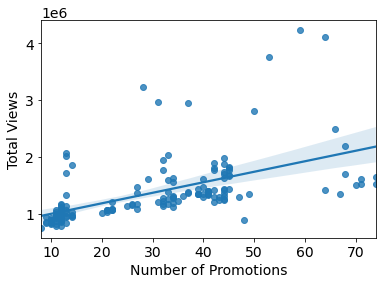

In [180]:
sns.regplot(x='num_promos',y='total_views',data=data1)

plt.xlabel('Number of Promotions')
plt.ylabel('Total Views')

plt.show()

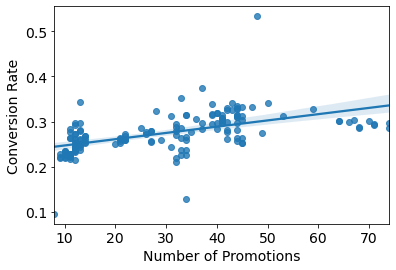

In [181]:
sns.regplot(x='num_promos',y='conversion_rate',data=data1)

plt.xlabel('Number of Promotions')
plt.ylabel('Conversion Rate')

plt.show()

In [176]:
import statsmodels.api as sm
import statsmodels.formula.api as sfm

model = sfm.ols('conversion_rate ~ num_promos',data=data1).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        conversion_rate   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     59.29
Date:                Mon, 19 Jul 2021   Prob (F-statistic):           1.66e-12
Time:                        10:06:30   Log-Likelihood:                 283.98
No. Observations:                 153   AIC:                            -564.0
Df Residuals:                     151   BIC:                            -557.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2335      0.006     37.373      0.0

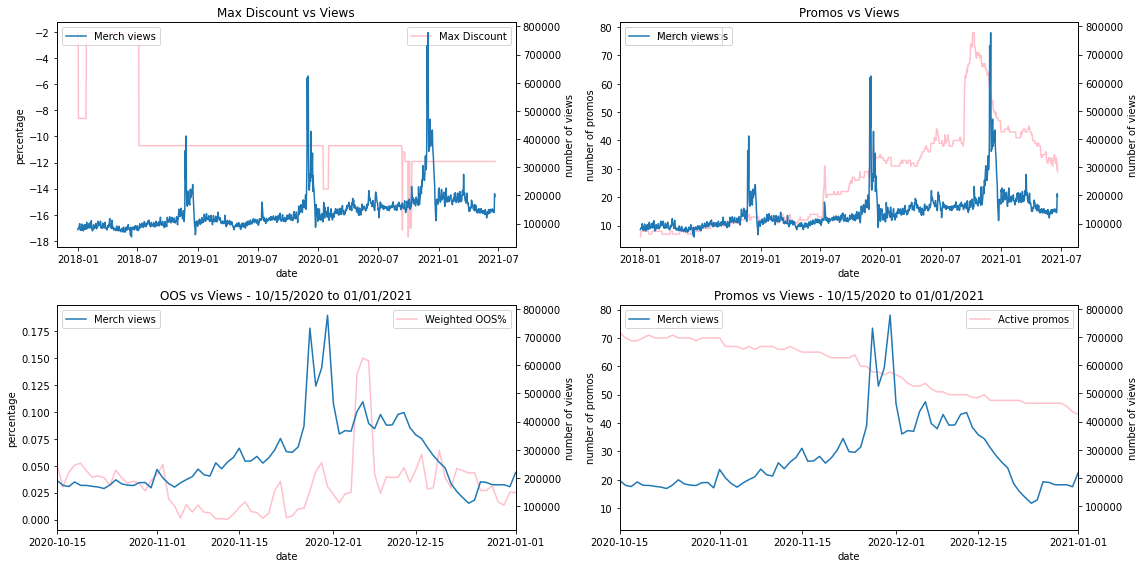

In [100]:
fig, axs = plt.subplots(2,2, figsize=(16,8))

# Plot 0
ax = axs[0,0]
sns.lineplot(x="date", y="promo_max_discount", data=df, label="Max Discount", ax=ax, color='pink')
ax_twin = ax.twinx()
sns.lineplot(x="date", y="merch_views", data=df, label="Merch views", ax=ax_twin)
ax.set_ylabel("percentage")
ax_twin.set_ylabel("number of views")
ax.set_title("Max Discount vs Views")
ax_twin.legend(loc=2)
ax.legend()

# Plot 1
ax = axs[0,1]
sns.lineplot(x="date", y="num_promos", data=df, label="Active promos", ax=ax, color='pink')
ax_twin = ax.twinx()
sns.lineplot(x="date", y="merch_views", data=df, label="Merch views", ax=ax_twin)
ax.set_ylabel("number of promos")
ax_twin.set_ylabel("number of views")
ax.set_title("Promos vs Views")
ax.legend()
ax_twin.legend(loc=2)

# Plot 3
ax = axs[1,0]
sns.lineplot(x="date", y="weighted_oos_rate", data=df, label="Weighted OOS%", ax=ax, color='pink')
ax_twin = ax.twinx()
sns.lineplot(x="date", y="merch_views", data=df, label="Merch views", ax=ax_twin)
ax.set_ylabel("percentage")
ax_twin.set_ylabel("number of views")
ax.set_title("OOS vs Views - 10/15/2020 to 01/01/2021")
ax_twin.legend(loc=2)
ax.legend()
ax.set_xlim(pd.to_datetime('10/15/2020'),pd.to_datetime('01/01/2021'))

# Plot 4
ax = axs[1,1]
sns.lineplot(x="date", y="num_promos", data=df, label="Active promos", ax=ax, color='pink')
ax_twin = ax.twinx()
sns.lineplot(x="date", y="merch_views", data=df, label="Merch views", ax=ax_twin)
ax.set_ylabel("number of promos")
ax_twin.set_ylabel("number of views")
ax.set_title("Promos vs Views - 10/15/2020 to 01/01/2021")
ax.legend()
ax_twin.legend(loc=2)
ax.set_xlim(pd.to_datetime('10/15/2020'),pd.to_datetime('01/01/2021'))

plt.tight_layout()

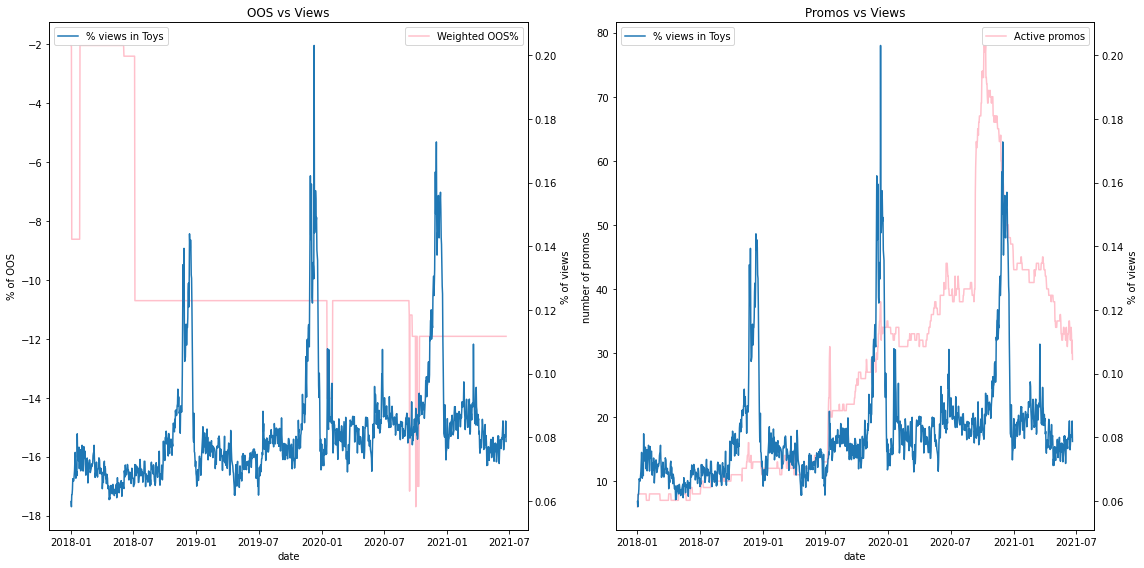

In [102]:
fig, axs = plt.subplots(1,2, figsize=(16,8))

# Plot 0
ax = axs[0]
sns.lineplot(x="date", y="promo_max_discount", data=df, label="Weighted OOS%", ax=ax, color='pink')
ax_twin = ax.twinx()
sns.lineplot(x="date", y="perc_views", data=df, label="% views in Toys", ax=ax_twin)
ax.set_ylabel("% of OOS")
ax_twin.set_ylabel("% of views")
ax.set_title("OOS vs Views")
ax_twin.legend(loc=2)
ax.legend()
# ax.set_xlim(pd.to_datetime('10/15/2020'),pd.to_datetime('01/01/2021'))

# Plot 1
ax = axs[1]
sns.lineplot(x="date", y="num_promos", data=df, label="Active promos", ax=ax, color='pink')
ax_twin = ax.twinx()
sns.lineplot(x="date", y="perc_views", data=df, label="% views in Toys", ax=ax_twin)
ax.set_ylabel("number of promos")
ax_twin.set_ylabel("% of views")
ax.set_title("Promos vs Views")
ax.legend()
ax_twin.legend(loc=2)
# ax.set_xlim(pd.to_datetime('10/15/2020'),pd.to_datetime('01/01/2021'))


plt.tight_layout()